In [1]:
import tensorflow as tf
# current processing
tf.config.set_visible_devices(tf.config.list_physical_devices('CPU'))

from importlib import import_module
import keras
from keras.api._v2 import keras as KerasAPI
keras: KerasAPI = import_module("tensorflow.keras")
print(tf.__version__)

from keras import layers
from keras.models import Sequential
from keras.layers import preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import time
import itertools

from sklearn.metrics import confusion_matrix



2.10.0


In [2]:
path = ''
# from google.colab import drive
# drive.mount('/content/drive')
# path = '/content/drive/MyDrive/deepLearningAs3/'

random_state_global = 42

pathfinal = path + 'model_history/model_arch_II/'
pathfinal2 = path + 'model_images/'

epoch_val = 3000
batch_size_val = 32
threshold_val = 1e-4
learning_rate_val = 1e-3

Hidden_layer_I_N = 20
Hidden_layer_II_N = 15
Hidden_layer_III_N = 10
Output_layer_N = 5


Hidden_layer_Activation = "tanh"
Output_layer_Activation = "softmax"



IMG_SIZE = (224, 224)
checkpoint_path = ''
train_dir = 'Group_20/train'
test_dir = 'Group_20/test'
val_dir = 'Group_20/val'

### Preparing Data

In [3]:
# unzip_data('Group_20.zip')

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


walk_through_dir('Group_20')

There are 3 directories and 1 images in 'Group_20'.
There are 5 directories and 0 images in 'Group_20/test'.
There are 0 directories and 20 images in 'Group_20/test/butterfly'.
There are 0 directories and 20 images in 'Group_20/test/helicopter'.
There are 0 directories and 20 images in 'Group_20/test/ketch'.
There are 0 directories and 20 images in 'Group_20/test/brain'.
There are 0 directories and 20 images in 'Group_20/test/ewer'.
There are 5 directories and 0 images in 'Group_20/train'.
There are 0 directories and 50 images in 'Group_20/train/butterfly'.
There are 0 directories and 50 images in 'Group_20/train/helicopter'.
There are 0 directories and 50 images in 'Group_20/train/ketch'.
There are 0 directories and 50 images in 'Group_20/train/brain'.
There are 0 directories and 50 images in 'Group_20/train/ewer'.
There are 5 directories and 0 images in 'Group_20/val'.
There are 0 directories and 10 images in 'Group_20/val/butterfly'.
There are 0 directories and 10 images in 'Group_2

image_0051.jpg
Image shape: (261, 300, 3)


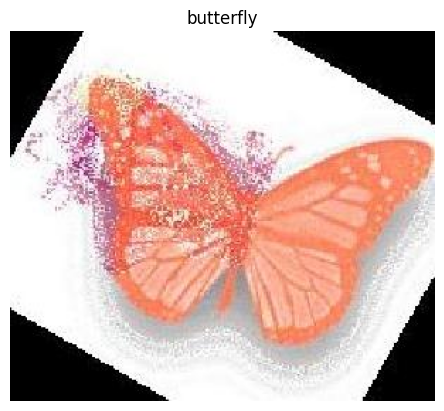

In [7]:
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = np.random.choice(os.listdir(target_folder))

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image)
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(random_image)
  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

# View a random image from the training dataset
img = view_random_image(target_dir="Group_20/test/",
                        target_class="butterfly")

In [8]:
# Setup data inputs

train_data = keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                seed=random_state_global,
                                                                batch_size = batch_size_val,
                                                                shuffle=True)
                                                                                
test_data = keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                seed=random_state_global,
                                                                batch_size = batch_size_val,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

valid_data = keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                seed=random_state_global,
                                                                batch_size = batch_size_val,
                                                                shuffle=False) # don't shuffle test data for prediction analysis
print(f'\nclass names are {train_data.class_names}')

Found 250 files belonging to 5 classes.
Found 100 files belonging to 5 classes.
Found 50 files belonging to 5 classes.

class names are ['brain', 'butterfly', 'ewer', 'helicopter', 'ketch']


### Callbacks

In [6]:
class ModelSaving(keras.callbacks.Callback):
    def __init__(self):
        self.currentEpoch = 0
        
    def on_epoch_end(self, epoch, logs=None):
        self.currentEpoch = epoch

    def on_train_end(self, logs=None):
        self.model.save(f'{pathfinal}{self.model.name}_{self.currentEpoch+1}.tf')
        # print("Training has ended!, model saved")

    
class HistorySaver(keras.callbacks.Callback):
    def __init__(self, initial_history):
        super(HistorySaver, self).__init__()
        self.history = {}
        self.currentEpoch = 0
        
        for key, value in [('loss', initial_history[0]), ('accuracy', initial_history[1]), ('val_loss', initial_history[2]), ('val_accuracy', initial_history[3])]:
            self.history.setdefault(key, []).append(value)
        
        # logs.items() = dict_items([('loss', 1.3612865209579468), ('accuracy', 0.46034255623817444), ('val_loss', 1.1157031059265137), ('val_accuracy', 0.6484848856925964)])
    def on_epoch_end(self, epoch, logs=None):
        for key, value in logs.items():
            self.history.setdefault(key, []).append(value)
        self.currentEpoch = epoch
        
    def on_train_end(self, logs=None):
        pd.DataFrame(self.history).to_csv(f'{pathfinal}{self.model.name}_{self.currentEpoch+1}.csv', index=False)
        # print("Training has ended!, model history saved")



# create the callbacks

model_saver = ModelSaving()

# This means if for 5 epochs the accuracy has no progress on 
# the validation set then it would stop and store the previous best value.
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='loss',
                                                  patience=1,
                                                  min_delta=threshold_val,
                                                  mode='min',
                                                  restore_best_weights=False, 
                                                  verbose=0)

checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         save_freq="epoch") # save the model weights which score the best validation accuracy) 